In [ ]:
!pip install pybullet
!pip install numpngw

     |████████████████████████████████| 90.8 MB 251 bytes/s 


In [ ]:
import PIL
import pybullet as p
import numpy as np
from numpngw import write_apng
from IPython.display import Image, display
from scipy import stats

In [ ]:
# steps / unit approx
step_units= {
	'gui':
			{
				'straight':60,
				'left':45,
				'right':50
			},
	'direct':
			{
				'straight':250,
				'left':160,
				'right':170
			}
}

step_ref={
	'straight':1,
	'left':0.5,
	'right':-0.5
}

forward_identifier={
	'straight':1,
	'left':0,
	'right':0
}
turn_identifier={
	'straight':0,
	'left':1,
	'right':1
}

In [ ]:
p.connect(p.DIRECT)
p.resetSimulation()
p.setGravity(0,0,-10)

In [ ]:
turtle = p.loadURDF("./sample_data/simple_turtle_modified.urdf",[-3,-2,0])
plane = p.loadURDF("./sample_data/plane_box.urdf")
box1 = p.loadURDF("./sample_data/box.urdf", [-3,0.5,0], useFixedBase=True)
box2 = p.loadURDF("./sample_data/box2.urdf", [0,-2.5,0], useFixedBase=True)
box3 = p.loadURDF("./sample_data/box3.urdf", [3.5,0,0], useFixedBase=True)


In [ ]:
# scanning ray initial data
ray_length = 10
beam_angles = [0, 90, 180, 270]

In [ ]:
# camera config data
yaw = 50
pitch = -35.0
roll = 0

upAxisIndex = 2

pixelWidth = 800
pixelHeight = 800

nearPlane = 0.01
farPlane = 1000
fov = 60

camTargetPos = [0, 0, 0]
cameraUp = [0, 0, 1]
cameraPos = [1, 1, 1]
camDistance = 5

viewMatrix = p.computeViewMatrixFromYawPitchRoll(camTargetPos, camDistance, yaw, pitch, roll, upAxisIndex)
aspect = pixelWidth / pixelHeight
projectionMatrix = p.computeProjectionMatrixFOV(fov, aspect, nearPlane, farPlane)			

def get_rendered_frame():
  return p.getCameraImage(pixelWidth,pixelHeight,viewMatrix,projectionMatrix)

In [ ]:
# collect the world bodies information 
num_bodies = p.getNumBodies()
body_dict = {body_id:p.getBodyInfo(body_id)[-1] for body_id in range(num_bodies)}
print(body_dict)


{0: b'most_simple_turtle', 1: b'plane', 2: b'long_box', 3: b'box2', 4: b'box3'}


In [ ]:
# prepare route and scanning array

def get_route(route):
	turn_arr=[0]
	forward_arr=[0]

	for motion_type, units in route:
		num_steps = step_units['direct'][motion_type]*units
		forward_arr.extend([forward_identifier[motion_type]*step_ref[motion_type]] * num_steps)
		turn_arr.extend([turn_identifier[motion_type]*step_ref[motion_type]] * num_steps)

	# final stop
	forward_arr.append(0)
	turn_arr.append(0)
	return forward_arr, turn_arr

def get_ray_data(from_ref, ray_length, theta):
	# Theta is orientation of robot
	ray_from = [from_ref]*len(beam_angles)
	ray_to = []
	for angle in beam_angles:
		ray_to.append([
			from_ref[0]+ray_length*np.cos(np.radians(angle)+theta),\
			from_ref[1]+ray_length*np.sin(np.radians(angle)+theta),\
			from_ref[2]
			])
	return ray_from, ray_to


In [ ]:
# prepare route
route = [('straight',1),('left',1)]#,('straight',1),('right',1),('straight',5),('left',1),('straight',2)]
forward_arr, turn_arr = get_route(route)
speed=10
NUM=len(forward_arr)
steps=NUM

In [ ]:
# capture the ray intersection and nearest obstacle information at each step
ray_intersection_data=[]
nearest_obstacle_in_step=[]
frames = []
lidar_data_full = []

In [ ]:
# run the simulation
while steps>0:
 p.stepSimulation()
 curr_pos, orientation = p.getBasePositionAndOrientation(turtle)
 roll, pitch, yaw = p.getEulerFromQuaternion(orientation)
 print(f'step: {steps} robot position {curr_pos[0]:0.2f},{curr_pos[1]:0.2f} yaw {yaw:0.3f}')
 
 #get the coordinates array for ray scans
 ray_start = [curr_pos[0], curr_pos[1], curr_pos[2]+0.2]
 ray_from, ray_to = get_ray_data(ray_start, ray_length, yaw)
 # get the ray scanning result 
 ray_intersection = p.rayTestBatch(ray_from, ray_to)
 # store the ray intersection result for each step
 lidar_data = [NUM-steps, curr_pos]
 # nearest objects in each step
 
 #A row in the below loop contains the interesection result of a ray
 #[bodyid, link index of the body, hit fraction along the ray, hit position, hit normal]
 for idx, intersection in enumerate(ray_intersection,1):
	 hit_fraction = intersection[2]
	 obs_distance = round(ray_length*hit_fraction,2)
	 body_name = 'None'
	 if hit_fraction < 1:
		 body_name = (body_dict[intersection[0]]).decode('utf-8')
	 lidar_data.append((idx, body_name, hit_fraction, obs_distance, intersection[3]))
 print(lidar_data)
 lidar_data_full.append(lidar_data)

 forward=forward_arr[(NUM-steps)]
 turn=turn_arr[(NUM-steps)]
 rightWheelVelocity = (forward+turn)*speed
 leftWheelVelocity  = (forward-turn)*speed

 p.setJointMotorControl2(turtle,0,p.VELOCITY_CONTROL,targetVelocity=leftWheelVelocity,force=100)
 p.setJointMotorControl2(turtle,1,p.VELOCITY_CONTROL,targetVelocity=rightWheelVelocity,force=100)
 steps -= 1
	# w, h, rgb, _, _  = get_rendered_frame()
	# np_frame = np.reshape(rgb, (h, w, 4))
	# steps-=1

	# if(steps%2):continue
	# frames.append(np_frame[:, :, :3])

step: 412 robot position -3.00,-2.00 yaw 0.000
[0, (-2.9999599033283304, -1.9999999990435262, 0.1080693343842346), (1, 'box2', 0.27499599033283306, 2.75, (-0.24999999999999978, -1.9999999779678859, 0.3080693343842346)), (2, 'long_box', 0.19999999990435263, 2.0, (-2.999959918656292, 2.220446049250313e-16, 0.30806933438423456)), (3, 'None', 1.0, 10.0, (0.0, 0.0, 0.0)), (4, 'None', 1.0, 10.0, (0.0, 0.0, 0.0))]
step: 411 robot position -3.00,-2.00 yaw 0.000
[1, (-2.9999198261800313, -1.9999999980874688, 0.11596110750863646), (1, 'box2', 0.2749919826180032, 2.75, (-0.25, -1.9999999559437112, 0.3159611075086365)), (2, 'long_box', 0.19999999980874694, 2.0, (-2.9999198568309304, 2.220446049250313e-16, 0.3159611075086365)), (3, 'None', 1.0, 10.0, (0.0, 0.0, 0.0)), (4, 'None', 1.0, 10.0, (0.0, 0.0, 0.0))]
step: 410 robot position -3.00,-2.00 yaw -0.000
[2, (-2.9998843053216038, -1.9999999965599347, 0.12367773313881807), (1, 'box2', 0.2749884305321604, 2.75, (-0.2500000000000002, -1.9999999998268

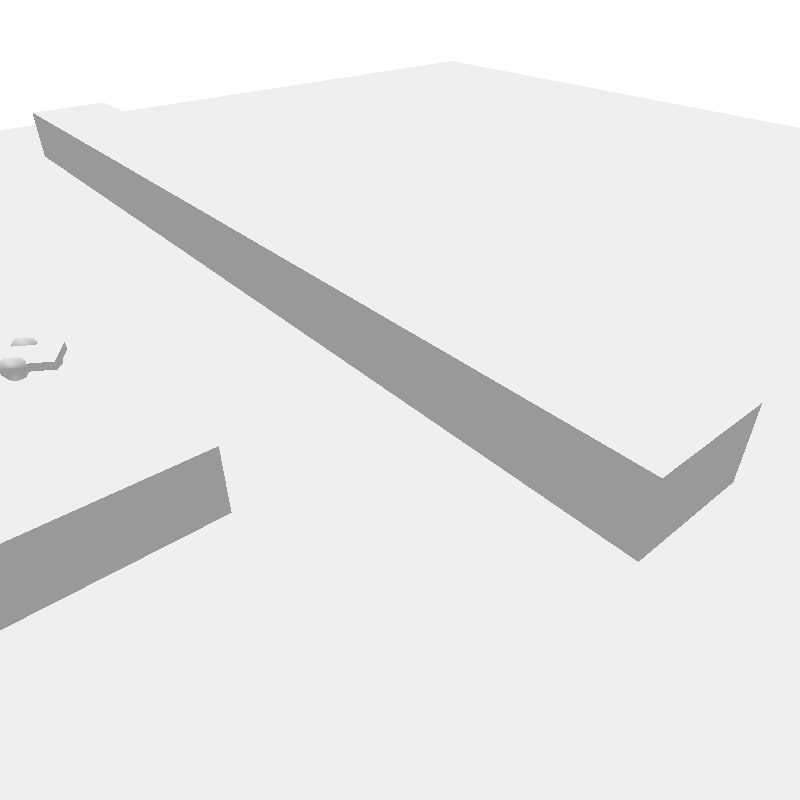

In [ ]:
w, h, rgb, _, _  = get_rendered_frame()
display(PIL.Image.fromarray(rgb, 'RGBA'))

##Task 1: Offline Visualizer (25 points)
1. Create a maze that mimics the robot world with 3 boxes
2. For every time step, plot the lidar beam that hits one of the boxes
3. Use funcanimation() in matplotlib to create a gif/ video

####Hints
1. Look at structure of lidar_data. End points of the beams that have hit fraction < 1 have to be extracted
2. Reuse the grid creation code from dynamic window avoidance notebook. Box dimensions can be obtained from URDF file. Box locations can be obtained in the initialization block

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation 

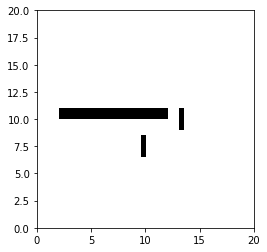

In [ ]:
#choose resolution and dimensions
grid_res = 0.5
grid_span =  20 # square circuit dimensions in m
offset = grid_span/2
#calculate grid_shape from grid
# dimensions have to be integers
grid_shape = (np.array([grid_span]*2)/grid_res).astype('int')
#Initialize 
grid_data = np.zeros(grid_shape)

#Create rectangular obstacles in world co-ordinates
#xmin, xmax, ymin, ymax
obstacles = np.array([[-8+offset,2+offset,0+offset,1+offset],[-0.25+offset,0.25+offset,-3.5+offset,-1.5+offset],\
                      [3.25+offset,3.75+offset,-1+offset,1+offset]])
for obs in obstacles:
    # calculate obstacles extent in pixel coords
    xmin, xmax, ymin, ymax = (obs/grid_res).astype('int')
    # mark them as occupied
    grid_data[xmin:xmax ,ymin:ymax ] = 1.0

#calculate the extents    
x1, y1 = 0, 0
x2, y2 = grid_span, grid_span

fig, ax = plt.subplots()
ax.set_xlim(0,grid_span)
ax.set_ylim(0,grid_span)
plt.imshow(1-grid_data.T, origin='lower', cmap=plt.cm.gray, extent=[x1,x2,y1,y2])
plt.show()

In [ ]:
print(xmin, xmax, ymin, ymax)

21 22 20 24


In [ ]:
line, = ax.plot(0,0)
def init():
  line.set_xdata([])
  line.set_ydata([])
  return line,

def lidar(i):
  x=[]
  y=[]
  elem = lidar_data_full[i]
  for j in range(2,len(elem)):
    if elem[j][2]<1.0:
      xStart = elem[1][0]
      yStart = elem[1][1]
      xEnd = elem[j][4][0]
      yEnd = elem[j][4][1]
      x.append([xStart+offset,xEnd+offset])
      y.append([yStart+offset,yEnd+offset])
  line.set_xdata(x)
  line.set_ydata(y)

  return line,

anim = animation.FuncAnimation(fig,lidar,init_func=init,frames=len(lidar_data_full),interval=10,blit=True)

anim.save('Offline_visualizer.mp4', writer = 'ffmpeg', fps = 30)

In [ ]:
p.disconnect(p.DIRECT)

error: ignored

##Task 2: Autonomous explorer (30 points)

Modify the code to enable the robot to explore the given maze autonomously. 

###Notes 
1. Suggested control is for the robot to choose the beam direction which has the least deviation from current orientation and obstacle free

2. Turtlebot is differentially-driven. You would have to change right-wheel and left-wheel velocities to effect straights and turns

3. Change the beam angles to span a smaller field-of-vision but more beams. Ex: [350, 355, 0, 5, 10]


In [ ]:
def get_ray_data(from_ref, ray_length, theta):
	# Theta is orientation of robot
	ray_from = [from_ref]*len(beam_angles)
	ray_to = []
	for angle in beam_angles:
		ray_to.append([
			from_ref[0]+ray_length*np.cos(np.radians(angle)+theta),\
			from_ref[1]+ray_length*np.sin(np.radians(angle)+theta),\
			from_ref[2]
			])
	return ray_from, ray_to

def RotnRadian(current_yaw,rotation_required,speed,condition,lidar_data_full,steps):
  # Input angles should be in radians
  old_yaw = current_yaw
  #print(old_yaw)
  new_yaw = current_yaw
  #print(new_yaw)
  diff = new_yaw - old_yaw
  while(abs(diff)<abs(rotation_required)):
    if rotation_required<0:
      # Clockwise Rotation
      rightWheelVelocity = -speed/2
      leftWheelVelocity  = speed/2
      print("break4")
    elif rotation_required>0:
      # Counter-Clockwise Rotation
      rightWheelVelocity = speed/2
      leftWheelVelocity  = -speed/2
      print("break5")
      
    # Move the robot
    p.setJointMotorControl2(turtle,0,p.VELOCITY_CONTROL,targetVelocity=leftWheelVelocity,force=100)
    p.setJointMotorControl2(turtle,1,p.VELOCITY_CONTROL,targetVelocity=rightWheelVelocity,force=100)
    p.stepSimulation()
    new_curr_pos, new_orientation = p.getBasePositionAndOrientation(turtle)
    _, _, new_yaw = p.getEulerFromQuaternion(new_orientation)


    ray_start = [new_curr_pos[0], new_curr_pos[1], new_curr_pos[2]+0.2]
    ray_from, ray_to = get_ray_data(ray_start, ray_length, new_yaw)
    # get the ray scanning result 
    ray_intersection = p.rayTestBatch(ray_from, ray_to)
    if condition=='FULL':
      # if all the rays are hitting the obstacle,then rotate only till the middle ray becomes free
      MiddleIndex = int((len(ray_intersection) - 1)/2)
      if ray_intersection[MiddleIndex][2]==1.0:
        return
    # else:
    #   pass

    lidar_data = [NUM-steps, new_curr_pos]
    # nearest objects in each step
    steps -= 1
    if steps<=1:
      return
    #A row in the below loop contains the interesection result of a ray
    #[bodyid, link index of the body, hit fraction along the ray, hit position, hit normal]
    for idx, intersection in enumerate(ray_intersection,1):
      hit_fraction = intersection[2]
      obs_distance = round(ray_length*hit_fraction,2)
      body_name = 'None'
      if hit_fraction < 1:
        body_name = (body_dict[intersection[0]]).decode('utf-8')
      lidar_data.append((idx, body_name, hit_fraction, obs_distance, intersection[3]))
    lidar_data_full.append(lidar_data)

    diff = new_yaw - old_yaw
    print(f"difference between angles is {diff}")
  return

def FindNearestFreeRay(ray_data,f):
  # f contains rays that are not hitting
  MiddleIndex = int((len(ray_data) - 1)/2) # 1 is subtracted to get indexing as in python.
  idxs = [] #start starting from 1
  for idx,_ in f:
    idxs.append(idx)
  # Subtract the middle index from every index of ray not hitting
  temp = [abs(elem - MiddleIndex) for elem in idxs]
  # find the minimum of above list to find the closet ray to middle ray which is not hitting
  MinIdx = temp.index(min(temp))
  return idxs[MinIdx],MiddleIndex

In [ ]:
p.connect(p.DIRECT)

1

In [ ]:
p.resetSimulation()
p.setGravity(0,0,-10)

In [ ]:
turtle = p.loadURDF("./sample_data/simple_turtle_modified.urdf",[0,5.5,0])
plane = p.loadURDF("./sample_data/plane_box.urdf")
box1 = p.loadURDF("./sample_data/box.urdf", [-10.5,5,0],p.getQuaternionFromEuler([0,0,np.pi/2]),useFixedBase=True)
box2 = p.loadURDF("./sample_data/box.urdf", [-10.5,-5,0],p.getQuaternionFromEuler([0,0,np.pi/2]),useFixedBase=True)
box3 = p.loadURDF("./sample_data/box.urdf", [10.5,5,0],p.getQuaternionFromEuler([0,0,np.pi/2]),useFixedBase=True)
box4 = p.loadURDF("./sample_data/box.urdf", [10.5,-5,0],p.getQuaternionFromEuler([0,0,np.pi/2]),useFixedBase=True)

box5 = p.loadURDF("./sample_data/box.urdf", [-5,9.5,0],useFixedBase=True)
box6 = p.loadURDF("./sample_data/box.urdf", [5,9.5,0],useFixedBase=True)
box7 = p.loadURDF("./sample_data/box.urdf", [-5,9.5,0],useFixedBase=True)
box8 = p.loadURDF("./sample_data/box.urdf", [5,-9.5,0],useFixedBase=True)

box9 = p.loadURDF("./sample_data/box2.urdf", [-5,5,0],useFixedBase=True)
box10 = p.loadURDF("./sample_data/box2.urdf", [5,5,0],useFixedBase=True)
box11 = p.loadURDF("./sample_data/box2.urdf", [-5,-5,0],useFixedBase=True)
box12 = p.loadURDF("./sample_data/box2.urdf", [5,-5,0],useFixedBase=True)
box13 = p.loadURDF("./sample_data/box2.urdf", [0,0,0],useFixedBase=True)

In [ ]:
# camera config data
yaw = 50
pitch = -35.0
roll = 0

upAxisIndex = 2

pixelWidth = 800
pixelHeight = 800

nearPlane = 0.01
farPlane = 1000
fov = 60

camTargetPos = [0, 0, 0]
cameraUp = [0, 0, 1]
cameraPos = [1, 1, 1]
camDistance = 5

viewMatrix = p.computeViewMatrixFromYawPitchRoll(camTargetPos, camDistance, yaw, pitch, roll, upAxisIndex)
aspect = pixelWidth / pixelHeight
projectionMatrix = p.computeProjectionMatrixFOV(fov, aspect, nearPlane, farPlane)			

def get_rendered_frame():
  return p.getCameraImage(pixelWidth,pixelHeight,viewMatrix,projectionMatrix)

In [ ]:
# collect the world bodies information 
num_bodies = p.getNumBodies()
body_dict = {body_id:p.getBodyInfo(body_id)[-1] for body_id in range(num_bodies)}
print(body_dict)

{0: b'most_simple_turtle', 1: b'plane', 2: b'long_box', 3: b'long_box', 4: b'long_box', 5: b'long_box', 6: b'long_box', 7: b'long_box', 8: b'long_box', 9: b'long_box', 10: b'box2', 11: b'box2', 12: b'box2', 13: b'box2', 14: b'box2'}


In [ ]:
# scanning ray initial data
ray_length = 5
beam_angles = [350, 355, 0, 5, 10]
#beam_angles = [330, 345, 0, 15, 30]
# find the gap between lidar beams. This works only if spacing b/w beams is uniform and tere are atleast 5 beams. in any other case, gap need to
# be filled manually
beam_angles_temp = np.array(beam_angles)
beam_angles_diff = np.diff(beam_angles)
beam_angles_mode = stats.mode(beam_angles_diff)
gap = np.deg2rad(beam_angles_mode[0][0])
steps = 5000
NUM=steps
speed=10

# capture the ray intersection and nearest obstacle information at each step
ray_intersection_data=[]
nearest_obstacle_in_step=[]
frames = []
lidar_data_full = []

In [ ]:
# run the simulation
while steps>0:
  p.stepSimulation()
  curr_pos, orientation = p.getBasePositionAndOrientation(turtle)
  roll, pitch, yaw = p.getEulerFromQuaternion(orientation)
  #print(f'step: {steps} robot position {curr_pos[0]:0.2f},{curr_pos[1]:0.2f} yaw {yaw:0.3f}')
  
  #get the coordinates array for ray scans
  ray_start = [curr_pos[0], curr_pos[1], curr_pos[2]+0.2]
  ray_from, ray_to = get_ray_data(ray_start, ray_length, yaw)
  # get the ray scanning result 
  ray_intersection = p.rayTestBatch(ray_from, ray_to)
  # store the ray intersection result for each step
  lidar_data = [NUM-steps, curr_pos]
  # nearest objects in each step
  steps -= 1
  #A row in the below loop contains the interesection result of a ray
  #[bodyid, link index of the body, hit fraction along the ray, hit position, hit normal]
  for idx, intersection in enumerate(ray_intersection,1):
    hit_fraction = intersection[2]
    obs_distance = round(ray_length*hit_fraction,2)
    body_name = 'None'
    if hit_fraction < 1:
      body_name = (body_dict[intersection[0]]).decode('utf-8')
    lidar_data.append((idx, body_name, hit_fraction, obs_distance, intersection[3]))
  print(lidar_data)
  lidar_data_full.append(lidar_data)

  f = []
  ray_data = lidar_data[2:] # getting only the data for rays
  #print(ray_data)
  f_temp = [ray_data[j][2] for j in range(len(ray_data))] # getting hit fraction for all rays
  f = [[idx,f_elem] for idx,f_elem in enumerate(f_temp) if f_elem == 1.0] # choosing all non hitting rays
  # print(f"f is {f}")
  if len(f)==len(ray_data):
    # if all rays non hitting, then ten simply move forward without turning
    print("run1")
    forward,turn = 1,0
  elif len(f)==0:
    # if all rays hitting then turn till the middle ray gets free or turn till 90 degree and move one step forward
    print("run2")
    # Turn 90 degrees clockwise or till the middle ray gets free, whichever is smaller
    RotnRadian(yaw,1.57,speed,'FULL',lidar_data_full,steps)
    forward,turn = 1,0
  else:
    print("run3")
    # find nearest free ray to middle ray
    nearest_free_ray_number,middle_ray_number = FindNearestFreeRay(ray_data,f)
    # find the angle by which robot has to turn to make middle ray free. if middle ray already free then angle will be zero.
    angle = (nearest_free_ray_number - middle_ray_number)*gap # -ve for clockwise, +ve for anticlockwise
    RotnRadian(yaw,angle,speed,'PARTIAL',lidar_data_full,steps)
    forward,turn = 1,0
    

  #  forward=forward_arr[(NUM-steps)]
  #  turn=turn_arr[(NUM-steps)]
  rightWheelVelocity = (forward+turn)*speed
  leftWheelVelocity  = (forward-turn)*speed
  p.setJointMotorControl2(turtle,0,p.VELOCITY_CONTROL,targetVelocity=leftWheelVelocity,force=100)
  p.setJointMotorControl2(turtle,1,p.VELOCITY_CONTROL,targetVelocity=rightWheelVelocity,force=100)

Streaming output truncated to the last 5000 lines.
[2573, (-8.164840613050291, 2.5166316670667057, 0.21136870752284975), (1, 'None', 1.0, 5.0, (0.0, 0.0, 0.0)), (2, 'None', 1.0, 5.0, (0.0, 0.0, 0.0)), (3, 'None', 1.0, 5.0, (0.0, 0.0, 0.0)), (4, 'None', 1.0, 5.0, (0.0, 0.0, 0.0)), (5, 'None', 1.0, 5.0, (0.0, 0.0, 0.0))]
run1
[2574, (-8.165364894858241, 2.512297223954575, 0.2109820725605296), (1, 'None', 1.0, 5.0, (0.0, 0.0, 0.0)), (2, 'None', 1.0, 5.0, (0.0, 0.0, 0.0)), (3, 'None', 1.0, 5.0, (0.0, 0.0, 0.0)), (4, 'None', 1.0, 5.0, (0.0, 0.0, 0.0)), (5, 'None', 1.0, 5.0, (0.0, 0.0, 0.0))]
run1
[2575, (-8.165863673717338, 2.507935660819117, 0.2112988455025168), (1, 'None', 1.0, 5.0, (0.0, 0.0, 0.0)), (2, 'None', 1.0, 5.0, (0.0, 0.0, 0.0)), (3, 'None', 1.0, 5.0, (0.0, 0.0, 0.0)), (4, 'None', 1.0, 5.0, (0.0, 0.0, 0.0)), (5, 'None', 1.0, 5.0, (0.0, 0.0, 0.0))]
run1
[2576, (-8.166362280536331, 2.5035756018300654, 0.21144189338863284), (1, 'None', 1.0, 5.0, (0.0, 0.0, 0.0)), (2, 'None', 1.0, 5

In [ ]:
print(len(ray_intersection))

5


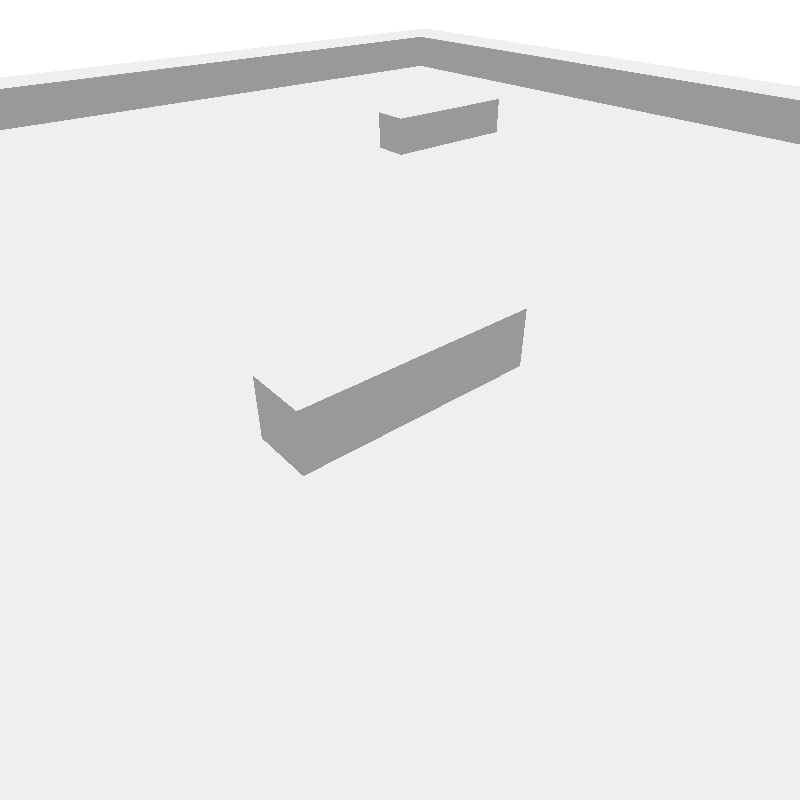

In [ ]:
w, h, rgb, _, _  = get_rendered_frame()
display(PIL.Image.fromarray(rgb, 'RGBA'))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation 

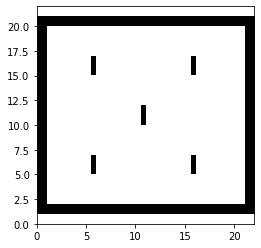

In [ ]:
#choose resolution and dimensions
grid_res = 0.5
grid_span =  22 # square circuit dimensions in m
offset = grid_span/2
#calculate grid_shape from grid
# dimensions have to be integers
grid_shape = (np.array([grid_span]*2)/grid_res).astype('int')
#Initialize 
grid_data = np.zeros(grid_shape)

obstacles = np.array([[-11+offset,-10+offset,0+offset,10+offset],[10+offset,11+offset,0+offset,10+offset],\
                      [-11+offset,-10+offset,-10+offset,0+offset],[10+offset,11+offset,-10+offset,0+offset],\
                     [-10+offset,0+offset,9+offset,10+offset],[0+offset,10+offset,9+offset,10+offset],\
                     [-10+offset,0+offset,-10+offset,-9+offset],[0+offset,10+offset,-10+offset,-9+offset],\
                      [-5.25+offset,-4.75+offset,4+offset,6+offset],[4.75+offset,5.25+offset,4+offset,6+offset],\
                      [-5.25+offset,-4.75+offset,-6+offset,-4+offset],[4.75+offset,5.25+offset,-6+offset,-4+offset],\
                      [-0.25+offset,0.25+offset,-1+offset,1+offset]])
for obs in obstacles:
    # calculate obstacles extent in pixel coords
    xmin, xmax, ymin, ymax = (obs/grid_res).astype('int')
    # mark them as occupied
    grid_data[xmin:xmax ,ymin:ymax] = 1.0

#calculate the extents    
x1, y1 = 0, 0
x2, y2 = grid_span, grid_span

fig, ax = plt.subplots()
ax.set_xlim(0,grid_span)
ax.set_ylim(0,grid_span)
plt.imshow(1-grid_data.T, origin='lower', cmap=plt.cm.gray, extent=[x1,x2,y1,y2])
plt.show()

In [ ]:
line, = ax.plot(0,0)
patch = plt.Circle((5, -10), 0.1, fc='r')
def init():
  patch.center = (-50, 50)
  ax.add_patch(patch)
  line.set_xdata([])
  line.set_ydata([])
  return line,patch

def lidar(i):
  x=[]
  y=[]
  xc,yc = -50,-50
  elem = lidar_data_full[i]
  for j in range(2,len(elem)):
    xc,yc = elem[1][0]+offset,elem[1][1]+offset
    if elem[j][2]<1.0:
      xStart = elem[1][0]
      yStart = elem[1][1]
      xEnd = elem[j][4][0]
      yEnd = elem[j][4][1]
      x.append([xStart+offset,xEnd+offset])
      y.append([yStart+offset,yEnd+offset])
  line.set_xdata(x)
  line.set_ydata(y)
  patch.center = (xc, yc)

  return line,patch

anim = animation.FuncAnimation(fig,lidar,init_func=init,frames=len(lidar_data_full),interval=10,blit=True)

# Takes about  min with default parameters
anim.save('Autonomous_navigator.mp4', writer = 'ffmpeg', fps = 30)